In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess Cats and Dogs dataset from TensorFlow Datasets
IMG_SIZE = (128, 128)

In [3]:
def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize to 128x128
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    image = image / 255.0  # Normalize pixel values
    return image, label

In [4]:
def load_dataset():
    dataset, info = tfds.load("cats_vs_dogs", split="train", with_info=True, as_supervised=True)
    dataset = dataset.map(preprocess_image).batch(32)
    return dataset

In [5]:
# Define Autoencoder model
def build_autoencoder(input_shape=(128, 128, 1)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Latent representation
    
    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [6]:
# Train Autoencoder and Extract Features
def train_autoencoder(epochs=4, batch_size=16):
    dataset = load_dataset()
    autoencoder = build_autoencoder()
    autoencoder.fit(dataset, epochs=epochs, batch_size=batch_size)
    
    # Extract encoder
    encoder = Model(autoencoder.input, autoencoder.get_layer(index=6).output)

    # Convert dataset to NumPy for efficient processing
    all_images = np.concatenate([batch[0] for batch in dataset], axis=0)

    # Get encoded features at once
    encoded_features = encoder.predict(all_images, verbose=0)
    
    # Flatten features
    encoded_features = encoded_features.reshape(len(all_images), -1)
    
    return autoencoder, encoder, encoded_features


In [7]:
# Clustering in Feature Space
def cluster_features(encoded_features, method='kmeans', num_clusters=2):
    if method == 'kmeans':
        clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
    else:
        clustering_model = GaussianMixture(n_components=num_clusters, random_state=42)
    labels = clustering_model.fit_predict(encoded_features)
    centroids = clustering_model.cluster_centers_ if hasattr(clustering_model, 'cluster_centers_') else clustering_model.means_
    return labels, centroids

In [8]:
# Regression-based Severity Prediction
def predict_severity(encoded_features, centroids):
    distances = np.linalg.norm(encoded_features[:, np.newaxis] - centroids, axis=2)
    probabilities = np.exp(-distances) / np.sum(np.exp(-distances), axis=1, keepdims=True)
    return probabilities

In [9]:
autoencoder, encoder, features = train_autoencoder()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.0PGQ4C_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Epoch 1/4
727/727 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.2501
Epoch 2/4
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.2500
Epoch 3/4
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.2500
Epoch 4/4
727/727 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.2500


In [10]:
labels, centroids = cluster_features(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
severity_scores = predict_severity(np.array(features), np.array(centroids))
severity_scores

array([[0.5032016 , 0.49679843],
       [0.49439663, 0.5056034 ],
       [0.50785494, 0.49214512],
       ...,
       [0.5143564 , 0.4856436 ],
       [0.48893377, 0.51106626],
       [0.49172512, 0.5082749 ]], dtype=float32)

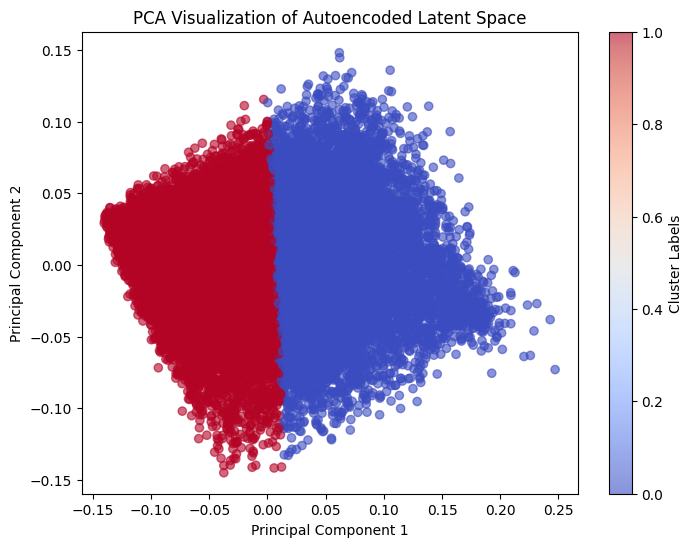

In [12]:
from sklearn.decomposition import PCA

def visualize_pca(encoded_features, labels=None):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(encoded_features)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label="Cluster Labels" if labels is not None else "Data Points")
    plt.title("PCA Visualization of Autoencoded Latent Space")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


visualize_pca(features, labels)
